In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import sys
import torch.nn as nn
import math
import copy
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score

sys.path.append('..')
import clip.clip as clip
from training.datasets import CellPainting
from clip.clip import _transform
from clip.model import convert_weights, CLIPGeneral, MLP
from preprocess.preprocess_molecules import morgan_from_smiles

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [4]:
molecule_path = "/home/jovyan/scratch-shared/Viktor/CLOOME/smiles.csv"
model_cloome_weights = "/home/jovyan/cloome/src/tests/MLP-bioativity.pt"
PCA_path = '/home/jovyan/scratch-shared/Viktor/CLOOME/PC.csv'

In [5]:
df = pd.read_csv(molecule_path)
df['smiles'] = df['smiles'].apply(morgan_from_smiles)
df.rename(columns={'SAMPLE_KEY':'compound', 'smiles':'morgan'}, inplace=True)
# Read the PCA values
df_PCA = pd.read_csv(PCA_path, sep=',')
df = df_PCA.merge(df, on='compound')
# Set a cutoff value for classification
cutoff = 25
df.insert(3, f'cutoff_{cutoff}', df['PC1'].apply(lambda x: 1 if x < cutoff else 0))
# Normalize PC1 & PC2
df['PC1'] = (df['PC1'] - df['PC1'].mean()) / df['PC1'].std()
df['PC2'] = (df['PC2'] - df['PC2'].mean()) / df['PC2'].std()
df = pd.concat([df, pd.DataFrame(df['morgan'].to_list())], axis=1)
df.drop(columns=['morgan'], inplace=True)
df.drop(columns='smiles', inplace=True)
# Hold the name of the columns with morgan fingerprints
morgan = [i for i in range(1024)]

In [6]:
df.head()

,compound,PC1,PC2,cutoff_25,0,1,2,3,4,5,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,BJ1896351,1.895638,0.057683,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,BJ1896476,3.292217,0.802591,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,BJ1894230,2.659518,0.043879,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,BJ1896063,1.236856,0.186389,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,BJ1896111,1.240770,1.071401,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [7]:
torch.Tensor(df.loc[0:3, morgan].values)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [8]:
df.loc[0:3, morgan]

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
test_tensor = torch.tensor(df.loc[0:3, morgan].values).float()
#MLP_model(test_tensor)
#print(type(test_tensor))
#print(test_tensor.shape)
#print(type(test_tensor[0]))
#print(test_tensor[0].shape)

In [10]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(df.loc[:,morgan], df['PC1'], test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1/0.8, random_state=0)

In [11]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(df.shape)

(3664, 1024)
(524, 1024)
(1048, 1024)
(5236, 1028)


In [12]:
class DatasetFeature(torch.utils.data.Dataset):
    def __init__(self, X, y):
        # Take X and y from dataframes
        self.X = torch.tensor(X.values, dtype=torch.float)
        self.y = torch.tensor(y.values, dtype=torch.float)
        
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [16]:
# Train linear layer
# Need to find out how to freez all layers exceptt the lasat linear one.
#=====================

# Train whole network with very small learning rate

def train(model, X_train, y_train, X_val, y_val, device, criterion=nn.MSELoss(), lr=0.00001, weight_decay=0, epochs=20, batch_size=32, class_weights=None, metric_func=lambda x, y: 0):
    """
    Input:
        metric_func: function that takes metric(target, prediction) and calculates a metric
    
    """
    # Create datasets
    train = DatasetFeature(X_train, y_train)
    val = DatasetFeature(X_val, y_val)
    train_dataloader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=False)
    val_dataloader = torch.utils.data.DataLoader(dataset=val, batch_size=val.__len__(), shuffle=False)
    # Model specifics
    criterion = criterion
    lr = lr
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    # Variables for the training loop:
    iter = 0
    train_loss = []
    val_loss = []
    train_metric = []
    val_metric = []
    best_model = np.nan
    best_loss = math.inf
    best_epoch = 0

    # Training loop
    for epoch in range(epochs):
        running_loss = 0.0
        running_metric = 0.0
        model.train()
        model.to(device)
        # Train model
        for i, (features, target) in enumerate(train_dataloader):
            batch_size = features.shape[0]
            optimizer.zero_grad()
            output = model(features.to(device)).view([batch_size])
            loss = criterion(output, target.to(device))
            metric = metric_func(output.cpu().data, target.cpu().data)
            metric = 0
            # Implement class weights
            if class_weights != None:
                weights = []
                for sample_target in target:
                    weights.append(class_weights[sample_target.int().item()])
                weights = torch.tensor(weights, dtype=torch.float).to(device)
                loss = loss * weights
                loss = loss.mean()
            running_loss += loss.item() * batch_size
            running_metric += metric * batch_size
            loss.backward()
            optimizer.step()
            iter += 1
        # Evaluate the model on validation dataset
        model.eval()
        for i, (features_val, target_val) in enumerate(val_dataloader):
            output_val = model(features_val.to(device)).view(val.__len__())
            loss = criterion(output_val, target_val.to(device)).item()
            metric = metric_func(output_val, target_val.cpu().numpy())
            val_loss.append(loss)
            val_metric.append(metric)
            if loss < best_loss:
                best_loss = loss
                best_model = copy.deepcopy(model)
                best_epoch = epoch
        train_loss.append(running_loss/train.__len__())
        train_metric.append(running_metric/train.__len__())
        print(f"Epoch {epoch} / {epochs}")
        print(f"Train loss: {train_loss[-1]}\tVal loss: {val_loss[-1]}")
    print(f"Best val loss: {best_loss}\tepoch {best_epoch}")

    return best_model, train_loss, val_loss, train_metric, val_metric, best_epoch

    # Train last linear layer

    # Train whole network with very 

In [15]:
MLP_model = MLP(input_dim=1024, hidden_dim=1024, output_dim=512, n_layers=4)
#MLP_model.load_state_dict(torch.load(model_cloome_weights))
MLP_model.load_state_dict(torch.load(model_cloome_weights, map_location=torch.device('cpu')))
MLP_model = nn.Sequential(MLP_model, nn.Linear(512, 1))

for name, param in MLP_model.named_parameters():
    if name.startswith('0'):
        param.requires_grad = False

temp_model, train_loss, val_loss = train(copy.deepcopy(MLP_model),
                                                               X_train=X_train,
                                                               y_train=y_train,
                                                               X_val=X_val,
                                                               y_val=y_val,
                                                               device=device,
                                                               lr = 0.000005,
                                                               weight_decay = 0.0,
                                                               epochs = 400)

tensor([ 0.0368,  0.0378,  0.0128,  0.0211,  0.0665,  0.0366,  0.0972,  0.0454,
         0.0234,  0.0916,  0.0242,  0.0601, -0.0085,  0.0300,  0.0335,  0.0404,
         0.0217,  0.0752,  0.1066,  0.0476,  0.0297,  0.0452,  0.0729,  0.0310,
         0.0721,  0.0100,  0.0396,  0.0491,  0.0568,  0.0668,  0.0408,  0.0433])
<class 'torch.Tensor'>
torch.Size([32])
tensor([ 0.2729, -0.8115, -1.2319, -0.8505,  0.0162,  0.0759,  1.8041, -1.9942,
         1.1680,  0.3515, -0.1815, -0.8964,  0.5401, -0.5913, -0.1056, -0.0147,
         2.4975,  0.8362,  0.0720, -1.8361,  1.6617,  0.4021,  0.8392, -0.1288,
         0.4948,  0.4473,  0.3875, -0.3496,  1.1610, -0.6360,  1.5131, -1.3329])
tensor([ 0.0559,  0.0431,  0.0102,  0.0462,  0.0182,  0.0731,  0.0408,  0.0491,
         0.0149,  0.0495,  0.0249,  0.0516,  0.0607,  0.0322,  0.0370,  0.0736,
         0.0569,  0.0394,  0.0222,  0.0237,  0.0572,  0.0889,  0.0289,  0.0782,
         0.0255,  0.0296, -0.0097,  0.0412,  0.0614,  0.0633,  0.0278,  0.0419

KeyboardInterrupt: 

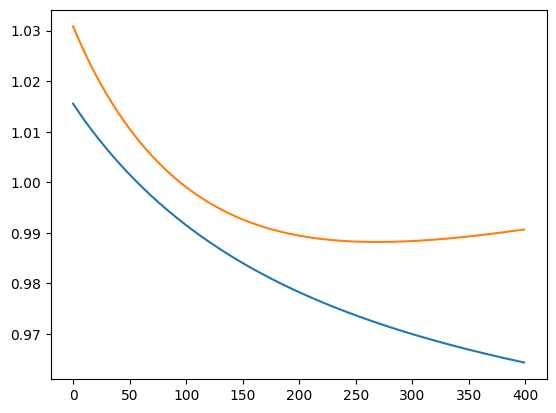

In [89]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.show()

<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
0.03890123030696724


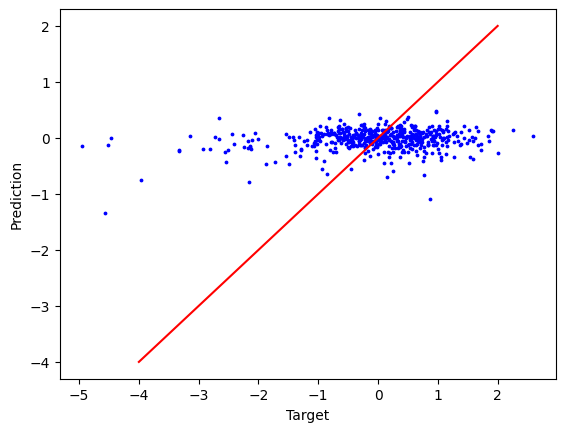

In [90]:
y_pred = temp_model(torch.Tensor(X_val.values).to(device)).cpu().detach().numpy()
print(type(y_pred))
print(type(y_val))
print(r2_score(y_val, y_pred))
plt.scatter(y_val, y_pred, s=3, c='b')
plt.plot((-4, 2), (-4, 2), c='r')
plt.xlabel('Target')
plt.ylabel('Prediction')
plt.show()

In [79]:
for name, param in temp_model.named_parameters():
    if name.startswith('0'):
        param.requires_grad = True

temp_model_2, train_loss, val_loss = train(copy.deepcopy(temp_model),
                                                    X_train=X_train,
                                                    y_train=y_train,
                                                    X_val=X_val,
                                                    y_val=y_val,
                                                    device=device,
                                                    lr = 0.000001,
                                                    weight_decay = 0.05,
                                                    epochs = 500)

Epoch 0 / 500
Train loss: 0.9720829748690909	Val loss: 0.9879949688911438
Epoch 1 / 500
Train loss: 0.9706083942188446	Val loss: 0.9877540469169617
Epoch 2 / 500
Train loss: 0.9690421491731203	Val loss: 0.9875215888023376
Epoch 3 / 500
Train loss: 0.9674590406980056	Val loss: 0.9872964024543762
Epoch 4 / 500
Train loss: 0.9658806709222919	Val loss: 0.9870717525482178
Epoch 5 / 500
Train loss: 0.9643049763279711	Val loss: 0.9868502020835876
Epoch 6 / 500
Train loss: 0.962740163355415	Val loss: 0.986635148525238
Epoch 7 / 500
Train loss: 0.961182910802583	Val loss: 0.9864234328269958
Epoch 8 / 500
Train loss: 0.9596357949435971	Val loss: 0.9862132668495178
Epoch 9 / 500
Train loss: 0.958095018259823	Val loss: 0.9860040545463562
Epoch 10 / 500
Train loss: 0.9565651286637419	Val loss: 0.9857999086380005
Epoch 11 / 500
Train loss: 0.9550439814292708	Val loss: 0.9855943322181702
Epoch 12 / 500
Train loss: 0.9535331400721354	Val loss: 0.9853935241699219
Epoch 13 / 500
Train loss: 0.9520332602

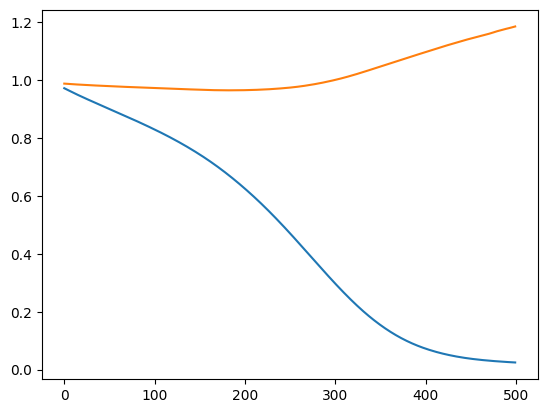

In [80]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.show()

<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
0.061637248849481185


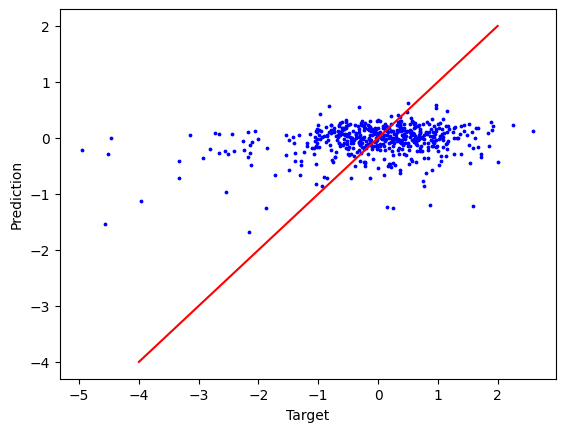

In [84]:
y_pred = temp_model_2(torch.Tensor(X_val.values).to(device)).cpu().detach().numpy()
print(type(y_pred))
print(type(y_val))
print(r2_score(y_val, y_pred))
plt.scatter(y_val, y_pred, s=3, c='b')
plt.plot((-4, 2), (-4, 2), c='r')
plt.xlabel('Target')
plt.ylabel('Prediction')
plt.show()

### Logistic regression / Classificaiton

In [98]:
df['cutoff_25'] = df['cutoff_25'].apply(lambda x: (x-1) * (-1))

In [14]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(df.loc[:,morgan], df['cutoff_25'], test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1/0.8, random_state=0)

In [16]:
def calc_class_weights(train, device):
    counts = train.value_counts()
    class_weights = []
    for i in [0, 1]:
        print(counts[i])
        class_weights.append(counts[i])
    print(len(class_weights))
    print(sum(class_weights))
    print(class_weights)
    print(type(counts))
    class_weights = 1 / (class_weights / sum(class_weights))
    class_weights = class_weights / class_weights.sum()
    return torch.tensor(class_weights, dtype=torch.float).to(device)
    

class_weights = calc_class_weights(y_train, device)
print(class_weights)

3531
133
2
3664
[3531, 133]
<class 'pandas.core.series.Series'>
tensor([0.0363, 0.9637], device='cuda:0')


In [130]:
def  calc_metrics(conf_matr):
    """
    Input: dataframe from pd.Categorical with categories=[0, 1] where 1 is the active class
    Output: precision, recall, and F1 score
    Complexity: Linear
    """
    TP = conf_matr.iloc[1, 1]
    FP = conf_matr.iloc[0, 1]
    FN = conf_matr.iloc[1, 0]
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    F1 = 2 * precision * recall / (precision + recall) if precision * recall  != 0 else 0.0
    return precision, recall, F1

def calc_F1(output, target):
    print(f"Pre {output.shape}")
    output = [1 if pred>0.5 else 0 for pred in output]
    output = pd.Categorical(output, categories=[0, 1])
    print(len(output))
    print(len(target))
    confusion_matrix = pd.crosstab(target, output)
    print('YOYOYOYOYOYOYOYOYOYOYOY')
    _, _, F1 = calc_metrics(confusion_matrix)
    print('YPYPYPYOYOYOYOOYYO')
    return F1

In [17]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
4775,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2251,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3811,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4012,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2424,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2809,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3047,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
2605,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2677,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [118]:
# Create the model, to get a logistic regression model just add a sigmoid function to the linear output
MLP_model_log = MLP(input_dim=1024, hidden_dim=1024, output_dim=512, n_layers=4)
MLP_model_log.load_state_dict(torch.load(model_cloome_weights))
MLP_model_log = nn.Sequential(MLP_model_log, nn.BatchNorm1d(512), nn.Linear(512, 512), nn.LeakyReLU(512), nn.Linear(512, 1))

for name, param in MLP_model_log.named_parameters():
    if name.startswith('0'):
        param.requires_grad = False

temp_model_log, train_loss, val_loss, train_metric, val_metric, best_epoch = train(copy.deepcopy(MLP_model_log),
                                                               X_train=X_train,
                                                               y_train=y_train,
                                                               X_val=X_val,
                                                               y_val=y_val,
                                                               criterion=nn.BCEWithLogitsLoss(),
                                                               device=device,
                                                               lr = 0.000001,
                                                               weight_decay = 0.1,
                                                               epochs = 10,
                                                               class_weights=class_weights)

tensor([-268.5313, -213.8605, -133.6884, -179.1637, -313.2748, -151.4550,
         -43.8220, -167.7910,  -99.0755, -191.6088,   29.7870,  -25.4297,
         -71.7561,  -57.8335,  -43.7828,  -50.0580,   -8.5879,  -41.3410,
        -163.2722, -108.0967, -103.7795, -106.5677,  -30.6955,  -44.7685,
         107.8476,  -15.2330, -173.9594,  100.0631,   69.8016, -140.6708,
        -176.7968,  -33.7221])
<class 'torch.Tensor'>
torch.Size([32])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])
tensor([-135.0853, -197.8126, -103.9265,  -17.2285,   57.2567,  -47.9159,
        -196.4772, -192.9777,  -47.4949,  -15.5611, -297.1571,  216.5131,
          82.9928, -109.6871,  -60.3452,  -58.2021, -102.3663,  -36.0541,
          19.7863, -235.9603, -162.1726,  -45.5307,   51.6452,  -51.2209,
         -68.0801, -346.5424, -276.7451, -144.0533,    6.5704,  -95.6691,
         -72.6040,  -35.1178])
<class 'torch

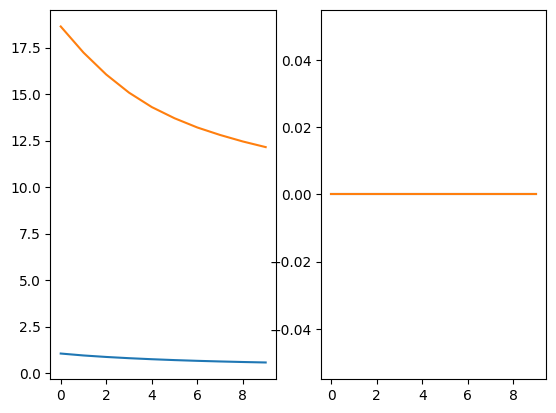

In [120]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.plot(train_loss)
ax1.plot(val_loss)
ax2.plot(train_metric)
ax2.plot(val_metric)
plt.show()

In [123]:
y_pred = temp_model_log(torch.Tensor(X_val.values).to(device)).cpu().detach().numpy()
y_pred = [1 if pred>0.5 else 0 for pred in y_pred]
y_pred = pd.Categorical(y_pred, categories=[0, 1])
confusion_matrix = pd.crosstab(y_val, y_pred)
precision, recall, F1 = calc_metrics(confusion_matrix)
print('YO')
print(type(y_pred))
print(type(y_val))
print('stop YO')
F1_other = calc_F1(y_pred, y_val)
print('Validation matrix')
print(confusion_matrix)
print(f"precision: {precision}")
print(f"recall: {recall}")
print(f"F1 score: {F1}")
print(f"F1 score: {F1_other}")

YO
<class 'pandas.core.arrays.categorical.Categorical'>
<class 'pandas.core.series.Series'>
stop YO
Pre (524,)
524
524
Validation matrix
col_0        0   1
cutoff_25         
0          453  44
1           24   3
precision: 0.06382978723404255
recall: 0.1111111111111111
F1 score: 0.08108108108108109
F1 score: 0.08108108108108109


In [67]:
y_pred = temp_model_log(torch.Tensor(X_train.values).to(device)).cpu().detach().numpy()
y_pred = [1 if pred>0.5 else 0 for pred in y_pred]
y_pred = pd.Categorical(y_pred, categories=[0, 1])
confusion_matrix = pd.crosstab(y_train, y_pred)
precision, recall, F1 = calc_metrics(confusion_matrix)
print('Train matrix')
print(confusion_matrix)
print(f"precision: {precision}")
print(f"recall: {recall}")
print(f"F1 score: {F1}")

Train matrix
col_0         0   1
cutoff_25          
0          3530   1
1           119  14
precision: 0.9333333333333333
recall: 0.10526315789473684
F1 score: 0.18918918918918917


In [68]:
y_pred = temp_model_log(torch.Tensor(X_val.values).to(device)).cpu().detach().numpy()
print(y_pred)

[[-7.24187613e+00]
 [-8.86701584e+00]
 [-1.13504601e+01]
 [-6.39945507e+00]
 [-5.09886122e+00]
 [ 2.35687733e+00]
 [-4.35585165e+00]
 [-5.32124138e+00]
 [-3.88740921e+00]
 [-7.20294142e+00]
 [-6.54608011e+00]
 [-3.53770137e+00]
 [-5.19167662e+00]
 [-8.22688103e+00]
 [-5.86112595e+00]
 [-3.45250654e+00]
 [-7.13536263e+00]
 [-9.77901268e+00]
 [-6.48793173e+00]
 [-5.24513674e+00]
 [-7.80519485e+00]
 [-3.79375839e+00]
 [-2.47596025e+00]
 [-9.83392334e+00]
 [-5.82920170e+00]
 [-6.68302393e+00]
 [-9.36678505e+00]
 [-7.17950487e+00]
 [-1.02181740e+01]
 [-7.16446352e+00]
 [-3.99981308e+00]
 [-6.25876951e+00]
 [-5.93596411e+00]
 [-5.67910337e+00]
 [-6.24152946e+00]
 [-3.24036360e+00]
 [-6.11578321e+00]
 [-5.73648167e+00]
 [-5.97996140e+00]
 [-5.95852137e+00]
 [-3.14277077e+00]
 [-2.35714102e+00]
 [-5.28404093e+00]
 [-3.99814987e+00]
 [-5.50495243e+00]
 [-5.33630419e+00]
 [-9.72235394e+00]
 [-1.82776093e-01]
 [-2.28658295e+00]
 [-5.02715111e+00]
 [-5.60102272e+00]
 [-4.48556376e+00]
 [-5.2189545

In [131]:
for name, param in temp_model_log.named_parameters():
    if name.startswith('0'):
        param.requires_grad = True

temp_model_log_2, train_loss, val_loss, best_epoch = train(copy.deepcopy(temp_model_log),
                                                               X_train=X_train,
                                                               y_train=y_train,
                                                               X_val=X_val,
                                                               y_val=y_val,
                                                               criterion=nn.BCEWithLogitsLoss(),
                                                               device=device,
                                                               lr = 0.00000005,
                                                               weight_decay = 0.1,
                                                               epochs = 200,
                                                               class_weights=class_weights, 
                                                               metric_func=calc_F1)

tensor([-309.5529, -237.4799, -144.2171, -184.1568, -321.0359, -169.6039,
         -89.4166, -199.7700, -145.4964, -238.1719,  -10.2724,  -50.6500,
        -114.8663, -120.2380,  -85.8366,  -96.5964,  -47.1031,  -75.2568,
        -172.3666, -137.8601, -151.0773, -103.3130,  -61.0083, -107.9184,
          27.0738,  -94.9620, -186.5399,   36.3162,   11.4997, -173.1382,
        -199.9541,  -96.2796])
<class 'torch.Tensor'>
torch.Size([32])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])
Pre torch.Size([32])
32
32
YOYOYOYOYOYOYOYOYOYOYOY


IndexError: index 1 is out of bounds for axis 0 with size 1

In [86]:
fig, (ax1, ax2) = plt.subplot(nrows=1, ncols=2)
ax1.plot(train_loss)
ax1.plot(val_loss)
ax2.plot(train_metric)
ax2.plot(val_metric)
plt.show()

TypeError: subplot() got an unexpected keyword argument 'ncols' and/or 'nrows'.  Did you intend to call subplots()?

In [78]:
y_pred = temp_model_log_2(torch.Tensor(X_val.values).to(device)).cpu().detach().numpy()
y_pred = [1 if pred>0.5 else 0 for pred in y_pred]
y_pred = pd.Categorical(y_pred, categories=[0, 1])
confusion_matrix = pd.crosstab(y_val, y_pred)
precision, recall, F1 = calc_metrics(confusion_matrix)
print('Validation matrix')
print(confusion_matrix)
print(f"precision: {precision}")
print(f"recall: {recall}")
print(f"F1 score: {F1}")

Validation matrix
col_0        0  1
cutoff_25        
0          496  1
1           26  1
precision: 0.5
recall: 0.037037037037037035
F1 score: 0.06896551724137931


In [87]:
device

'cuda'